## GPLVM - Oil Flow Data

This example uses oil flow dataset provided here:

https://inverseprobability.com/3PhaseData.html

Before running this notebook, you have to download gzipped MAT-file and ungzip it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, gpx, kernels

In [2]:
jax.config.update('jax_enable_x64', True)

In [3]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

## Generate Data

In [4]:
oil_flow_dataset = scipy.io.loadmat('3Class.mat')
oil_flow_dataset.keys()

dict_keys(['DataTrn', 'DataTrnFrctns', 'DataTrnLbls', 'DataTst', 'DataTstFrctns', 'DataTstLbls', 'DataVdn', 'DataVdnFrctns', 'DataVdnLbls'])

In [5]:
y = oil_flow_dataset['DataTrn']
y.shape

(1000, 12)

In [6]:
y_mu = y.mean(axis=0)
y_sd = y.std(axis=0)

y_scaled = (y - y_mu) / y_sd

In [7]:
GT = oil_flow_dataset["DataTrnLbls"].nonzero()[1]
np.unique(GT)

array([0, 1, 2])

## Define Inducing Vectors

In [8]:
ndim_latent = 2
num_inducing_pts = 100

Xu = gp.setup_inducing_normal(jax.random.PRNGKey(2), ndim_latent, num_inducing_pts)

## Define Model

In [9]:
def model(y, xu, ndim_latent):

    num_data = y.shape[0]   # number of data
    num_feat = y.shape[1]   # number of feature

    #
    # Sample Latent Variable
    #

#    dist_latent = dist.MultivariateNormal(loc=jnp.zeros(ndim_latent), covariance_matrix=jnp.eye(ndim_latent))
    dist_latent = dist.Normal(0, 1).expand([ndim_latent]).to_event(1)
    x_latent = numpyro.sample('x_latent', dist_latent, sample_shape=(num_data,))

    #
    # Define Kernel Function
    #

    rho = numpyro.sample('rho', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfNormal(10))
    kf = lambda x, y : var * kernels.rbf(x, y, rho)
    
    #
    # Define GP
    #

    xu_ = numpyro.param('xu', xu)
    jitter = numpyro.sample('jitter', dist.HalfNormal(1))
    noise_sd = numpyro.sample('noise_sd', dist.HalfNormal(10))

    W, D = gpx.sparse_vfe(kf, x_latent, xu_, noise_sd, jitter)
    dist_gp = dist.LowRankMultivariateNormal(loc=jnp.zeros(num_data), cov_factor=W, cov_diag=D)

    #
    # Set Observed Data
    #

    with numpyro.plate('feature', size=num_feat):

        numpyro.sample('obs', dist_gp, obs=y.transpose())


## Inference

In [10]:
guide = numpyro.infer.autoguide.AutoNormal(model)

optimizer = numpyro.optim.Adam(step_size=0.001)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())

In [11]:
%%time
svi_result = svi.run(jax.random.PRNGKey(0), 10000, y=y_scaled, xu=Xu, ndim_latent=ndim_latent)

100%|██████████| 10000/10000 [01:57<00:00, 85.28it/s, init loss: 66965.5318, avg. loss [9501-10000]: 6213.2369]


CPU times: user 3min 57s, sys: 6min 39s, total: 10min 37s
Wall time: 2min 2s


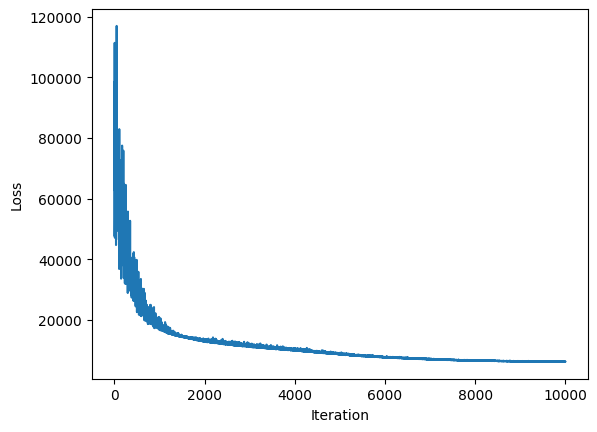

In [12]:
plt.plot(svi_result.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Check Samples

To use arviz's visualization, posterior samples are generated as (2, 1000) to mimic 2-chain MCMC-samples.

In [13]:
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(2), svi_result.params, sample_shape=(2, 1000))

idata = az.from_dict(posterior_samples)

In [14]:
az.summary(idata, var_names=['rho', 'var', 'jitter'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.424,0.003,0.418,0.430,0.000,0.000,2117.0,1895.0,1.0
var,0.991,0.034,0.923,1.049,0.001,0.001,2059.0,1848.0,1.0
jitter,0.001,0.000,0.001,0.001,0.000,0.000,1952.0,1962.0,1.0


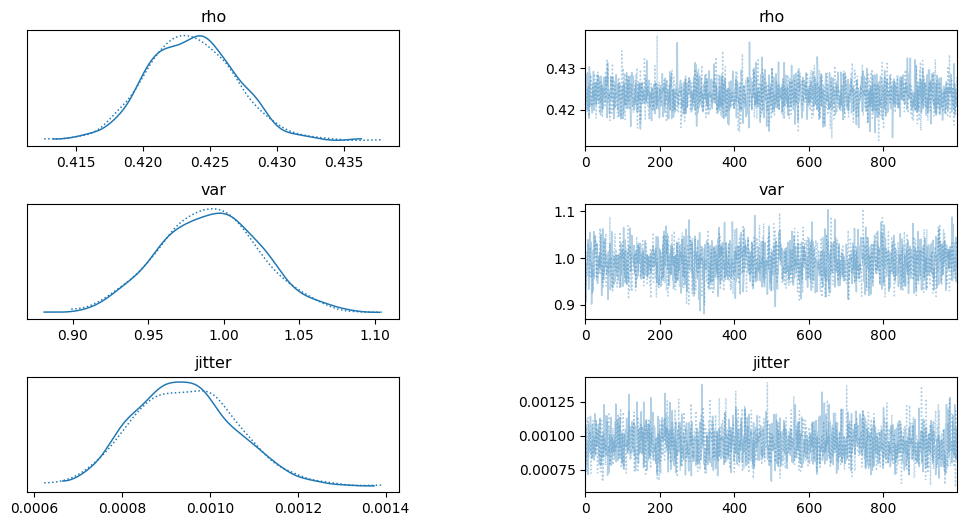

In [15]:
az.plot_trace(idata, var_names=['rho', 'var', 'jitter'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Visualize Latent Variables

In [16]:
x_latent = posterior_samples['x_latent'][0, ...]
x_latent = np.mean(x_latent, axis=0)
x_latent.shape

(1000, 2)

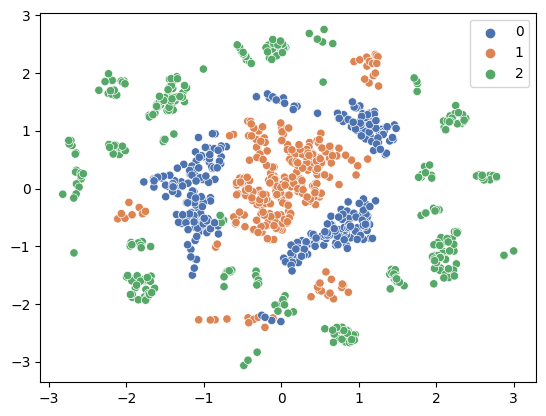

In [17]:
sns.scatterplot(x=x_latent[:, 0], y=x_latent[:, 1], hue=GT, palette='deep')
plt.show()

## Reference

[1] Bishop, C.M. and James G.D. (1993) Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research, Section A, 327, 580-593.

[2] Bishop, C.M. (2006) Pattern Recognition and Machine Learning. Springer